# EEG Wheelchair Binary Classification ML Model
## Using 1D Convolutional Networks and Recurrent Networks
This is the first experiment with trying to convert 4 channel EEG brain wave data into a binary classification of stop and go for the EEG wheelchair control system.

## Overview
The following notebook will follow these next steps:
1. Data Cleaning
    - Get rid of inconsistent samples or bad samples
2. Data Preprocessing
    - Convert to wavelet transforms and take signal squeezed signals
3. Data Filtering
    - Filter out irrelevant frequencies and disconnections
4. Build Model
    - Form CNN-RNN network for prediction modelling
5. Model Training
    - Train model on training set of EEG Samples
6. Hyperparameter Optimization
    - Optimize model hyperparameters by cross validation 
7. Model Validation
    - Validate model on test set


# Trial 1
## Summary
This is the initial trial with a few different tests, just trying to see if we can get data running and
training to start and make a few predictions

![overview diagram](docs/model_overview_diagram.jpg)

In [1]:
# Basic imports
from datetime import datetime
import numpy as np
import glob
import os
import sys
from collections import defaultdict
from sklearn.utils import shuffle

# Data management
import pandas as pd

# Data processing
from ssqueezepy import ssq_cwt

# Model training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf
import matplotlib.pyplot as plt

## Importing Data

In [ ]:
# Read test EEG data from dat directory
test_file = pd.read_csv('data/STOP/dk1_1673481784.csv', header=None)
test_file

In [2]:
# Pull all file data
files = defaultdict(list)

# Number of files per category to pull
num_files = len(min((glob.glob('./data/GO/*.csv'), glob.glob('./data/STOP/*.csv'), glob.glob('./data/REST/*.csv')),
                key=len))

for i, file in enumerate(glob.glob('./data/GO/*.csv')):
    if i == num_files:
        break
    files["GO"].append(pd.read_csv(file, header=None))
    
for i, file in enumerate(glob.glob('./data/REST/*.csv')):
    if i == num_files:
        break
    files["REST"].append(pd.read_csv(file, header=None))
    
for i, file in enumerate(glob.glob('./data/STOP/*.csv')):
    if i == num_files:
        break
    files["STOP"].append(pd.read_csv(file, header=None))

## Convert to wavelet transform signal squeezed

In [3]:
def ts_to_ssq(timeseries):
    """
    Converts 4 channel time series data to ssq wavelet transform
    """
    timestamps, tp9, af7, af8, tp10 = timeseries
    
    # Get the frequency of the samples 
    start = datetime.strptime(str(timestamps[0]), "%Y-%m-%d %H:%M:%S.%f")
    end = datetime.strptime(str(timestamps[-1]), "%Y-%m-%d %H:%M:%S.%f")
    duration = (end-start).total_seconds()
    fs = timestamps.size/duration
    
    Twtp9, _, *_ = ssq_cwt(tp9, fs=fs)
    Twtp10, _, *_ = ssq_cwt(tp10, fs=fs)
    Twaf7, _, *_ = ssq_cwt(af7, fs=fs)
    Twaf8, _, *_ = ssq_cwt(af8, fs=fs)
    
    return np.array((Twtp9, Twaf7, Twaf8, Twtp10))

In [ ]:
# Try test file

# Convert to numpy arrays
timestamps, tp9, af7, af8, tp10 = test_file.T.to_numpy()

# Get the frequency of the samples 
start = datetime.strptime(str(timestamps[0]), "%Y-%m-%d %H:%M:%S.%f")
end = datetime.strptime(str(timestamps[-1]), "%Y-%m-%d %H:%M:%S.%f")
duration = (end-start).total_seconds()
fs = timestamps.size/duration

Twtp9, Wtp9, *_ = ssq_cwt(tp9, fs=fs)
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(3, 1, 2)
plt.imshow(np.abs(Twtp9), aspect='auto', cmap='turbo')
fig.add_subplot(3, 1, 1)
plt.imshow(np.abs(Wtp9), aspect='auto', cmap='turbo')
plt.show()


In [4]:
# Compile all files into test data
X = []
t = []

key_dict = {"STOP":(0.0, 0.0, 1.0),
            "GO":(0.0, 1.0, 0.0),
            "REST": (1.0, 0.0, 0.0)}

original_sample_size = 3000
desired_sample_size = 25

num_files = sum([len(x) for x in files.values()])
                
for key, data in files.items():
    for recording in data:
        if not num_files%10:
            print("%d files left to convert" % num_files)
        num_files -= 1
        
        # if file is smaller than 3000 samples, don't use it
        if len(recording[0]) < original_sample_size:
            continue
        
        # Convert to numpy arrays
        ssq_data = ts_to_ssq((recording.head(original_sample_size).T.to_numpy()))
        
        # Take the magnitude of the wavelet transform only
        ssq_data = np.abs(ssq_data)
        
        # Must transpose data to (frame, height, channel) for training
        ssq_data = ssq_data.transpose(2,1,0)
        
        # Split sample into many blocks
        samples = np.split(ssq_data, int(original_sample_size/desired_sample_size))
        
        X.extend(samples)
        t.extend([key_dict[key] for i in range(len(samples))])
        

130 files left to convert
120 files left to convert
110 files left to convert
100 files left to convert
90 files left to convert
80 files left to convert
70 files left to convert
60 files left to convert
50 files left to convert
40 files left to convert
30 files left to convert
20 files left to convert
10 files left to convert


In [5]:
print(len(X), X[0].shape)
print(len(t), t[0])

16440 (25, 253, 4)
16440 (0.0, 1.0, 0.0)


In [ ]:
# Save the ssq data
if os.path.isdir('processed_data'):
    os.remove('processed_data/examples.npy')
    os.remove('processed_data/targets.npy')
else:
    os.mkdir('processed_data')
np.save('processed_data/examples.npy', X)
np.save('processed_data/targets.npy', t)

## *Shortcut: Load Preprocessed Saved Data*

In [ ]:
# Load ssq data
X = np.load('processed_data/examples.npy')
t = np.load('processed_data/targets.npy')

## Questions

- Do you think we need to normalize?

## Shuffle and split data to test and train

In [6]:
# Shuffle the data
SEED = 1
X, t = shuffle(X, t, random_state=SEED)

# Split the data into training and validation
# Lets try 10% test data for now
train_test_ratio = 0.10

X_test, X_train = np.split(X, [int(len(X)*train_test_ratio)])
t_test, t_train = np.split(t, [int(len(t)*train_test_ratio)])


In [7]:
X_train.shape

(14796, 25, 253, 4)

## Model Creation & Training

### Multi channel Convolution
![Multi channel convolution](https://i.stack.imgur.com/uDgke.gif)

### Time Distributed Convolution
![Time distributed convolution](https://miro.medium.com/max/720/1*0FUQ39KESKNNrsKh3h48ww.webp)

## 1st attempt
- Validation split of 10 % of training data
- batch size : 10
- epochs : 10
- 4 channel input -> 4 to 1 channel time distributed CNN -> LSTM RNN -> Dense layers (relu)
- Loss = mean squared error

### Expected results
- A loss of below 0.1 is what I'm aiming for

### Issues noticed
- Loss progressively goes down, then suddenly up
    - Could signify impurity in training data, need to clean up data
- Loss saturates at about 0.21
    - The model capacity seems to be able to predict by 0.21
    - Perhaps need to change training data quality
    - Perhaps need to improve model architecture
- Waiting to observe accuracy
    - accuracy stuck at about 49%
    - Most likely because using relu activation, because it should be for linear activation
    


In [ ]:
# Declare a sequential model
model = Sequential()

# Declare input shape of
model.add(Input(shape=X_train[0].shape)) # shape = frames, height, channels

# First add Convolution and Pooling layers
model.add(TimeDistributed(Conv1D(253, (3))))
model.add(TimeDistributed(Activation('relu')))

model.add(TimeDistributed(Conv1D(253, (2))))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))

# Flatten to prepare for Recurrent network
model.add(TimeDistributed(Flatten()))

# Recurrent layers connect to each of the time steps
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))

# Output is 3, REST, GO, STOP likelihood
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), 'accuracy'])

In [ ]:
model.summary()

In [ ]:
stdout = sys.stdout
f = open("trial_1.txt", 'w')
sys.stdout = f
results = model.fit(X_train, t_train, validation_split=0.1, batch_size=10, epochs=10)
sys.stdout = stdout
f.close()

## 2nd attempt
- Validation split of 10 % of training data
- batch size : 10
- epochs : 10
- 4 channel input -> 4 to 1 channel time distributed CNN -> LSTM RNN -> Dense layers (relu) -> Dense Layers (softmax)
- loss function = categorical cross entropy

### Changes made
- Changed last layer activation function to softmax instead of relu
    - Softmax more suited for multiclass classification
    - might be able to kick it above 50%
- Changed the loss calculation function to categorical cross-entropy
    - mean squared loss best for binary classification
    - Use categorical cross-entropy hopefully can make this a multiclass problem

### Expected results
- A loss of below 0.1 is what I'm aiming for
- Training accuracy should be more than 50% now

### Issues noticed
- Epochs seem to stabilize too early
    - Could mean that the model isn't fully capturing the data
    - Could mean that there isn't enough differentiation in the data
    


In [ ]:
# Declare a sequential model
model = Sequential()

# Declare input shape of
model.add(Input(shape=X_train[0].shape)) # shape = frames, height, channels

# First add Convolution and Pooling layers
model.add(TimeDistributed(Conv1D(253, (3))))
model.add(TimeDistributed(Activation('relu')))

model.add(TimeDistributed(Conv1D(253, (2))))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))

# Flatten to prepare for Recurrent network
model.add(TimeDistributed(Flatten()))

# Recurrent layers connect to each of the time steps
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))

# Output is 3, REST, GO, STOP likelihood
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
stdout = sys.stdout
f = open("results/trial1/attempt2.txt", 'w')
sys.stdout = f
results = model.fit(X_train, t_train, validation_data=(X_test, t_test), batch_size=5, epochs=10)
sys.stdout = stdout
f.close()

In [ ]:
plt.plot(results.history['accuracy'])

In [ ]:
model.predict(X_test[:10])

## 3rd attempt
- Validation split of 10 % of training data
- batch size : 5
- epochs : 10
- 4 channel input -> 4 to 1 channel time distributed CNN -> GRU RNN -> Dense layers (leaky relu) -> Dense Layers (softmax)
- loss function = categorical cross entropy

### Changes made
- GRU was added
- Used equal numbers of each training class

### Expected results
- Prediction should be different for different samples

### Issues noticed
- WOW, it worked amazing
- Looks like more epochs might be able to help reach convergence
- LSTM might be able to reach even higher accuracy
    


In [ ]:
# Declare a sequential model
model = Sequential()

# Declare input shape of
model.add(Input(shape=X_train[0].shape)) # shape = frames, height, channels

# First add Convolution and Pooling layers
model.add(TimeDistributed(Conv1D(253, (3))))
model.add(TimeDistributed(Activation('relu')))

model.add(TimeDistributed(Conv1D(253, (2))))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))

# Flatten to prepare for Recurrent network
model.add(TimeDistributed(Flatten()))

# Recurrent layers connect to each of the time steps
model.add(GRU(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu')
         )
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))

# Output is 3, REST, GO, STOP likelihood
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.get_weights()

In [ ]:
results = model.fit(X_train, t_train, validation_data=(X_test, t_test), batch_size=5, epochs=10)

In [ ]:
model.get_weights()

In [ ]:
model.evaluate(X_test, t_test)

In [ ]:
model.predict(X_test[204:210])

In [ ]:
t_test[204:210]

In [ ]:
# SAVE THIS MODEL RIGHT NOW, IT'S TOO GOOD
model.save('attempt3.h5')

In [ ]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(('accuracy', 'val_accuracy'))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(('loss', 'val_loss'))
plt.xlabel("Epoch")
plt.ylabel("Loss")

## 4th attempt
- Validation split of 10 % of training data
- batch size : 5
- epochs : 50
- 4 channel input -> 4 to 1 channel time distributed CNN -> GRU RNN -> Dense layers (relu) -> Dense Layers (softmax)
- loss function = categorical cross entropy

### Changes made
- Using LSTM, hopefully increase the model capacity for RNN
- Making sample size 50 frames to create more training data, and align with more prediction results
- More epochs to see if we can reach convergence later

### Expected results
- Hopefully the same or better than previous

### Issues noticed
- Too many epochs, overfitting
- smaller frame size worked very well
    


In [ ]:
# Declare a sequential model
model = Sequential()

# Declare input shape of
model.add(Input(shape=X_train[0].shape)) # shape = frames, height, channels

# First add Convolution and Pooling layers
model.add(TimeDistributed(Conv1D(253, (3))))
model.add(TimeDistributed(Activation('relu')))

model.add(TimeDistributed(Conv1D(253, (2))))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))

# Flatten to prepare for Recurrent network
model.add(TimeDistributed(Flatten()))

# Recurrent layers connect to each of the time steps
model.add(GRU(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu')
         )
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))

# Output is 3, REST, GO, STOP likelihood
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.get_weights()

In [ ]:
results = model.fit(X_train, t_train, validation_data=(X_test, t_test), batch_size=5, epochs=50)

In [ ]:
model.get_weights()

In [ ]:
model.evaluate(X_test, t_test)

In [ ]:
model.predict(X_test[204:210])

In [ ]:
t_test[204:210]

In [ ]:
# To save the model
model.save('attempt4.h5')

In [ ]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(('accuracy', 'val_accuracy'))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

## 5th attempt
- Validation split of 10 % of training data
- batch size : 5
- epochs : 10
- 4 channel input -> 4 to 1 channel time distributed CNN -> LSTM RNN -> Dense layers (leaky relu) -> Dense Layers (softmax)
- loss function = categorical cross entropy

### Changes made
- Test data is independent 5%
- Making sample size 25 frames to create more training data, and align with more prediction results
- Finding ideal epoch

### Expected results
- Hopefully the same or better than previous

### Issues noticed
nothing really
    


In [8]:
# Declare a sequential model
model = Sequential()

# Declare input shape of
model.add(Input(shape=X_train[0].shape)) # shape = frames, height, channels

# First add Convolution and Pooling layers
model.add(TimeDistributed(Conv1D(253, (3))))
model.add(TimeDistributed(Activation('relu')))

model.add(TimeDistributed(Conv1D(253, (2))))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))

# Flatten to prepare for Recurrent network
model.add(TimeDistributed(Flatten()))

# Recurrent layers connect to each of the time steps
model.add(GRU(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu')
         )
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))

# Output is 3, REST, GO, STOP likelihood
model.add(Dense(3, activation='softmax'))

2023-01-31 09:39:56.678285: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-01-31 09:39:56.769400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: Tesla K20Xm computeCapability: 3.5
coreClock: 0.732GHz coreCount: 14 deviceMemorySize: 5.57GiB deviceMemoryBandwidth: 232.46GiB/s
2023-01-31 09:39:56.770135: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-01-31 09:39:56.774571: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-31 09:39:56.777633: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-01-31 09:39:56.778375: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 25, 251, 253)      3289      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 251, 253)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 25, 250, 253)      128271    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 25, 250, 253)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 25, 125, 253)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 25, 31625)         0         
_________________________________________________________________
gru (GRU)                    (None, 128)               1

In [11]:
model.get_weights()

[array([[[-0.00152386,  0.08551845, -0.0354191 , ...,  0.08388056,
           0.05573797, -0.01760985],
         [-0.05539665, -0.0702982 , -0.05784642, ..., -0.04883428,
           0.05132629,  0.01793314],
         [-0.07644868, -0.03775431, -0.08142625, ..., -0.04539184,
          -0.04706084,  0.0167158 ],
         [ 0.00340575, -0.06849146, -0.07842553, ..., -0.05681074,
          -0.01455121,  0.00801622]],
 
        [[ 0.03480283, -0.03045186, -0.07373079, ...,  0.06725273,
           0.05938394,  0.07815535],
         [-0.04825986,  0.00138092, -0.07927895, ..., -0.04354231,
          -0.06877241,  0.08725901],
         [ 0.06243159,  0.04642181,  0.07425302, ..., -0.00985189,
          -0.06004258,  0.02353257],
         [ 0.04025091, -0.05197731, -0.05682361, ...,  0.07810046,
          -0.04720586,  0.0211337 ]],
 
        [[ 0.06760003, -0.01763357, -0.07333414, ..., -0.00874882,
          -0.05288215, -0.01657972],
         [ 0.05316104,  0.00237096, -0.08196303, ..., -0.0

In [12]:
stdout = sys.stdout
f = open("attempt5.txt", 'w')
sys.stdout = f
results = model.fit(X_train, t_train, validation_split=0.1, batch_size=5, epochs=7)
sys.stdout = stdout
f.close()

2023-01-31 09:40:06.999967: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-31 09:40:07.245111: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-01-31 09:48:11.691417: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-01-31 09:48:11.866434: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [13]:
model.get_weights()

[array([[[-0.06873642,  0.03556494,  0.05890158, ...,  0.19729064,
          -0.01170243, -0.08463546],
         [-0.04776452, -0.09955262, -0.05280499, ..., -0.01525663,
          -0.0027851 ,  0.09514932],
         [ 0.0217943 , -0.13902783, -0.3916146 , ...,  0.02722673,
          -0.09318976,  0.18944623],
         [-0.00782776, -0.2234294 , -0.08317155, ..., -0.02403215,
          -0.0522429 , -0.02686965]],
 
        [[ 0.12867905, -0.29349893, -0.2723209 , ...,  0.09074581,
           0.00441144,  0.18974352],
         [-0.00627376,  0.08630265, -0.07364646, ...,  0.10808345,
          -0.11182091,  0.16479048],
         [ 0.14281483,  0.15702681,  0.07521389, ...,  0.09192689,
          -0.10686193,  0.11905215],
         [ 0.06775694, -0.09753311,  0.08992624, ...,  0.11489547,
          -0.06852217,  0.02405681]],
 
        [[ 0.10578112,  0.05574411,  0.09658611, ..., -0.03838436,
          -0.06942981,  0.07903651],
         [-0.02370248, -0.0282052 ,  0.01155752, ..., -0.0

In [14]:
model.evaluate(X_test, t_test)

52/52 [==============================] - 5s 106ms/step - loss: 0.0317 - accuracy: 0.9897


[0.03167857229709625, 0.9896593689918518]

In [15]:
model.predict(X_test[204:210])

array([[9.1859517e-13, 1.0000000e+00, 3.0587342e-09],
       [1.0000000e+00, 2.0123206e-35, 6.5530872e-30],
       [1.1125849e-14, 7.3133569e-11, 1.0000000e+00],
       [8.2874813e-15, 1.0000000e+00, 2.1774749e-11],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.6749643e-32, 2.0107395e-28]], dtype=float32)

In [16]:
t_test[204:210]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [17]:
# To save the model
model.save('attempt5.h5')

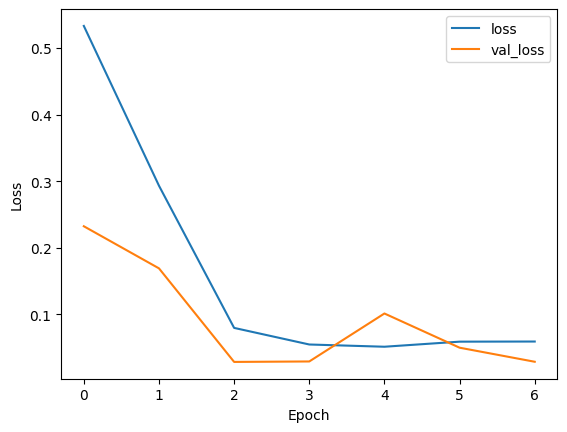

In [21]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(('loss', 'val_loss'))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('attempt5_loss.png')

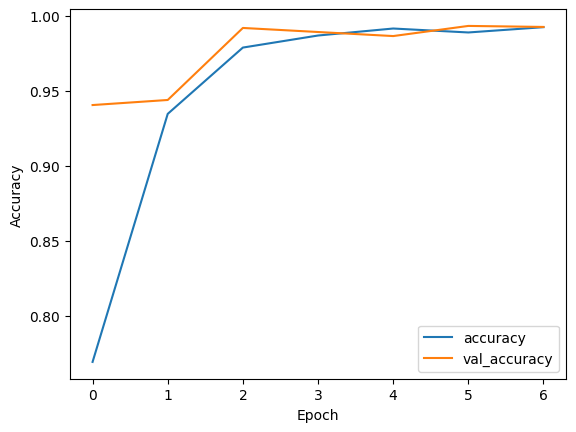

In [22]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(('accuracy', 'val_accuracy'))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig('attempt5_accuracy.png')

# Appendix

## Useful Diagams and links
![recurrent diagram](docs/recurrent_model_diagram.png)
![cnn diagram](docs/conv_model_diagram.png)

https://levelup.gitconnected.com/hands-on-practice-with-time-distributed-layers-using-tensorflow-c776a5d78e7e